In [1]:
# %pip install joblib

# XYZ location

In [2]:
file1 = "recordings/recording_20260120_172104.wav"
file2 = "recordings/recording_20260120_172104_logitech.wav"


[▶] Loading audio
[✓] Loading audio done in 0.50s

[▶] STFT


STFT channels: 100%|██████████| 18/18 [00:00<00:00, 89.86it/s]

[✓] STFT done in 0.21s

[▶] SRP coarse


[✓] SRP coarse done in 0.19s


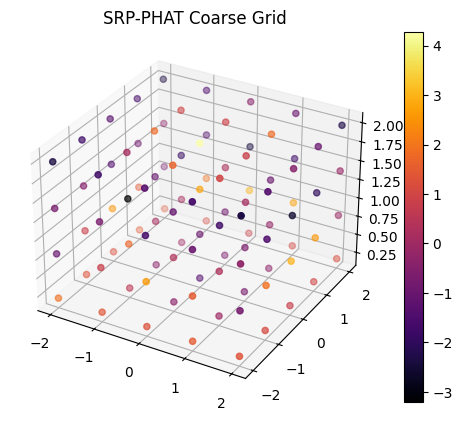


[▶] SRP fine
[✓] SRP fine done in 0.06s


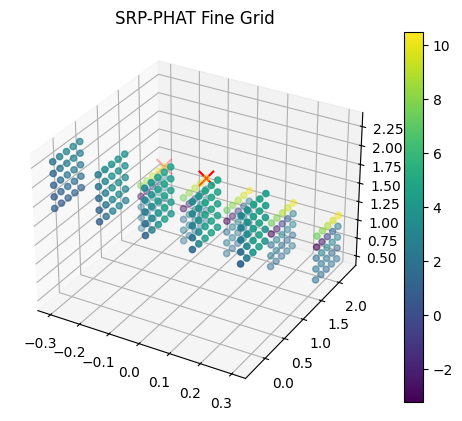

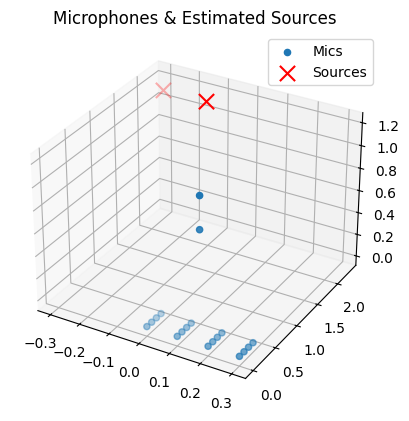


[▶] MVDR
[✓] MVDR done in 3.16s


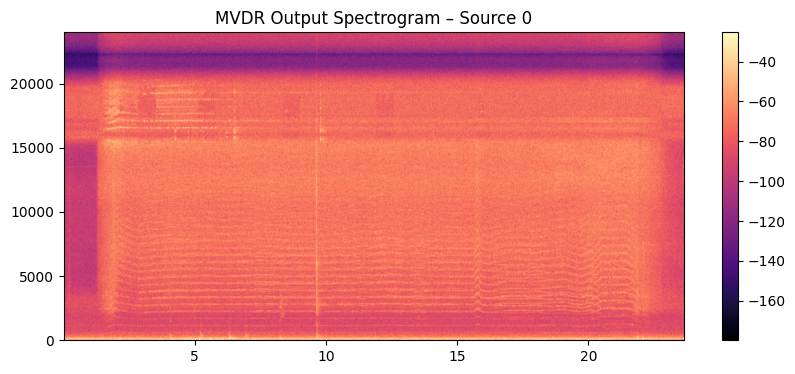

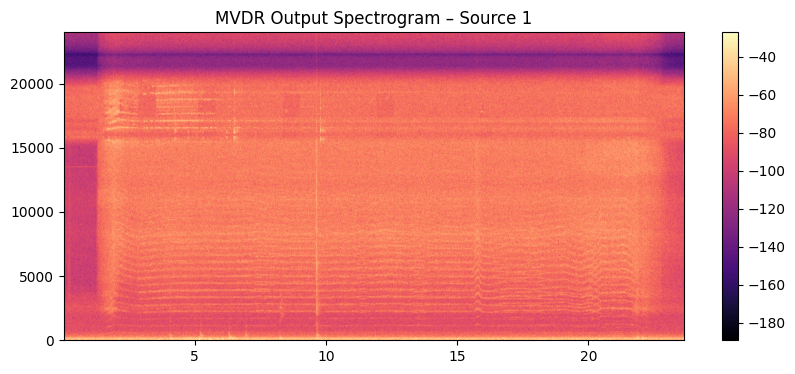

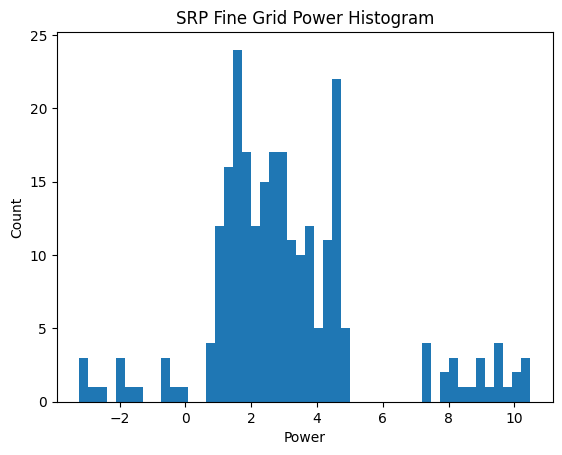

In [3]:
#!/usr/bin/env python3
"""
FINAL STABLE VERSION
SRP-PHAT (fast) + MVDR (correct) + FULL VISUALIZATION
"""

import time
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft, resample_poly
from scipy.linalg import pinv
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from contextlib import contextmanager
import joblib
from mpl_toolkits.mplot3d import Axes3D

# ======================
# PARAMETERS
# ======================
C = 343.0
FS = 48000
NFFT = 256
HOP = 64
N_SOURCES = 2
N_JOBS = multiprocessing.cpu_count()

FREQ_SUB = 4
PAIR_DIST_MIN = 0.15

# ======================
# MIC POSITIONS
# ======================
mic_positions = np.array([
    [0.0, 0.0, 0.0], [0.1, 0.0, 0.0], [0.2, 0.0, 0.0], [0.3, 0.0, 0.0],
    [0.0, 0.1, 0.0], [0.1, 0.1, 0.0], [0.2, 0.1, 0.0], [0.3, 0.1, 0.0],
    [0.0, 0.2, 0.0], [0.1, 0.2, 0.0], [0.2, 0.2, 0.0], [0.3, 0.2, 0.0],
    [0.0, 0.3, 0.0], [0.1, 0.3, 0.0], [0.2, 0.3, 0.0], [0.3, 0.3, 0.0],
    [0.15, 0.15, 0.9144], [0.15, 0.15, 1.2]
])
MIC_COUNT = mic_positions.shape[0]

# ======================
# UTILITIES
# ======================
@contextmanager
def timed(name):
    print(f"\n[▶] {name}")
    t0 = time.perf_counter()
    yield
    print(f"[✓] {name} done in {time.perf_counter()-t0:.2f}s")

@contextmanager
def tqdm_joblib(tqdm_obj):
    class Callback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_obj.update(self.batch_size)
            return super().__call__(*args, **kwargs)
    old = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = Callback
    try:
        yield
    finally:
        joblib.parallel.BatchCompletionCallBack = old
        tqdm_obj.close()

# ======================
# LOAD AUDIO
# ======================
def load_resample(path):
    x, fs = sf.read(path)
    if x.ndim == 1:
        x = x[:, None]
    if fs != FS:
        g = np.gcd(fs, FS)
        x = resample_poly(x, FS//g, fs//g, axis=0)
    return x

with timed("Loading audio"):
    a1 = load_resample(file1)
    a2 = load_resample(file2)
    L = min(len(a1), len(a2))
    audio = np.vstack([a1[:L].T, a2[:L].T])

# ======================
# STFT
# ======================
def stft_ch(x):
    _, _, Z = stft(x, FS, nperseg=NFFT, noverlap=NFFT-HOP, boundary=None)
    return Z

with timed("STFT"):
    with tqdm_joblib(tqdm(total=audio.shape[0], desc="STFT channels")):
        X = np.array(Parallel(
            n_jobs=N_JOBS, backend="threading", batch_size=1
        )(delayed(stft_ch)(ch) for ch in audio))

# ======================
# FREQUENCIES
# ======================
freqs_full = np.arange(X.shape[1]) * FS / NFFT
FIDX = np.arange(2, X.shape[1], FREQ_SUB)
freqs_srp = freqs_full[FIDX]

# ======================
# SRP PRECOMPUTE
# ======================
Xmean = np.mean(X[:, FIDX, :] * np.conj(X[:, FIDX, :]), axis=2)

pairs = [
    (i, j) for i in range(MIC_COUNT) for j in range(i+1, MIC_COUNT)
    if np.linalg.norm(mic_positions[i] - mic_positions[j]) > PAIR_DIST_MIN
]

def srp_point(g):
    s = 0.0
    for i, j in pairs:
        tau = (np.linalg.norm(g - mic_positions[i])
             - np.linalg.norm(g - mic_positions[j])) / C
        phase = np.exp(-2j*np.pi*freqs_srp*tau)
        R = Xmean[i] * np.conj(Xmean[j])
        R /= np.abs(R) + 1e-12
        s += np.real(np.sum(R * phase))
    return s

# ======================
# SRP COARSE
# ======================
GRID_X = np.linspace(-2, 2, 5)
GRID_Y = np.linspace(-2, 2, 5)
GRID_Z = np.linspace(0.2, 2.0, 4)
grid_coarse = np.array(np.meshgrid(GRID_X, GRID_Y, GRID_Z)).reshape(3, -1).T

with timed("SRP coarse"):
    P1 = np.array(Parallel(n_jobs=N_JOBS)(
        delayed(srp_point)(g) for g in grid_coarse))

# --- Plot SRP Coarse ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(grid_coarse[:,0], grid_coarse[:,1], grid_coarse[:,2], c=P1, cmap='inferno')
ax.set_title("SRP-PHAT Coarse Grid")
plt.colorbar(sc)
plt.show()

# ======================
# SRP FINE
# ======================
seeds = grid_coarse[np.argsort(P1)[-N_SOURCES:]]

def refine(c, r=0.3, n=5):
    x = np.linspace(c[0]-r, c[0]+r, n)
    y = np.linspace(c[1]-r, c[1]+r, n)
    z = np.linspace(c[2]-r, c[2]+r, n)
    return np.array(np.meshgrid(x, y, z)).reshape(3, -1).T

grid_fine = np.vstack([refine(s) for s in seeds])

with timed("SRP fine"):
    P2 = np.array(Parallel(n_jobs=N_JOBS)(
        delayed(srp_point)(g) for g in grid_fine))

src_positions = grid_fine[np.argsort(P2)[-N_SOURCES:]]

# --- Plot SRP Fine ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(grid_fine[:,0], grid_fine[:,1], grid_fine[:,2], c=P2, cmap='viridis')
ax.scatter(src_positions[:,0], src_positions[:,1], src_positions[:,2],
           c='red', s=120, marker='x')
ax.set_title("SRP-PHAT Fine Grid")
plt.colorbar(sc)
plt.show()

# ======================
# MIC + SOURCE GEOMETRY
# ======================
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mic_positions[:,0], mic_positions[:,1], mic_positions[:,2], label="Mics")
ax.scatter(src_positions[:,0], src_positions[:,1], src_positions[:,2],
           c='red', marker='x', s=120, label="Sources")
ax.legend()
ax.set_title("Microphones & Estimated Sources")
plt.show()

# ======================
# MVDR
# ======================
def steering(freq, pos):
    return np.exp(-2j*np.pi*freq *
                  np.linalg.norm(mic_positions - pos, axis=1) / C)

def mvdr_bin(f, pos):
    R = X[:, f, :] @ X[:, f, :].conj().T
    Rinv = pinv(R)
    a = steering(freqs_full[f], pos)
    w = Rinv @ a / (a.conj().T @ Rinv @ a + 1e-12)
    return w.conj().T @ X[:, f, :]

separated = []

with timed("MVDR"):
    for pos in src_positions:
        Y = np.array(Parallel(n_jobs=N_JOBS)(
            delayed(mvdr_bin)(f, pos) for f in range(X.shape[1])))
        _, y = istft(Y, FS, nperseg=NFFT, noverlap=NFFT-HOP)
        y /= np.max(np.abs(y)) + 1e-12
        separated.append(y)

# ======================
# MVDR SPECTROGRAMS
# ======================
for i, s in enumerate(separated):
    plt.figure(figsize=(10,4))
    plt.specgram(s, NFFT=1024, Fs=FS, noverlap=512, cmap='magma')
    plt.title(f"MVDR Output Spectrogram – Source {i}")
    plt.colorbar()
    plt.show()

# ======================
# SRP POWER HISTOGRAM
# ======================
plt.figure()
plt.hist(P2, bins=50)
plt.title("SRP Fine Grid Power Histogram")
plt.xlabel("Power")
plt.ylabel("Count")
plt.show()
